# ML講座の課題
* 【Coding内容の覚書】
* 3月14日
* 3月15日現在での自身の内部課題の調査／解決法の追加
* 3月20日 日時データDatetime, dt アクセサ
* 3月23日 Category化とcat アクセサ
* 3月27日 最終DataFrame
* 3月28～ 初回：ロジスティック回帰 98.9%(おかしい？） 
* 4月2日　説明変数の修正＝＞下記の編集は募集の終了時点のデータのため、利用しない
　+ usd_pledge_real, usd_goal_real, backer
* 4月6、７日 交差検証（K=5）、Strtified交差検証、線形/非線形SVM、決定木
* 4月12日　ランダムフォレスト、アダブースト

## 【各方式での正答率】
  + ロジスティック回帰 ＝ 61.530%
  + ホールドアウト法＝ 60.247%
  + Stratified Split＝ 61.618%
  + Cross_Valid平均 ＝ 56.538%
  + Stratified型CrossValid平均 ＝ 57.678%
  + 線形SVM　 ＝ 59.741%
  + 非線形SVM ＝ 64.732%
  + 決定木　　＝ 64.342%
  + ランダムフォレスト＝ 61.969%
  + アダブースト　　　＝ 66.965%
  
* 【課題】
  1. CR-FDの募金金額データについて、外れ値の処理（±２σ、±３σ）の検討と実施
  1. 木の図化

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, sys

## 1.Kaggleデータについて
<ol>利用データが、２タイプ（201801）あり、利用するデータセットを決定する
    <BR>個別に読み込み、下記項目を確認<BR>
<li>欠損値の有無、データ構成</li>
<li>データフレーム内のコラム（説明変数）</li>
        </ol>
    

## 1.1 データ読み込みと実行確認（最初5行を読み出し確認）
【調査結果】<BR>
2016データには、コラム名に複数の未定義・欠損値があるために、<BR>
また、Indexの最初部分は同一のため、2018側のデータセットを利用する

In [2]:
df_2016 = pd.read_csv("../DATA/kickst/ks-projects-201612.csv", encoding="ISO-8859-1", low_memory=False)

In [3]:
display(df_2016.head())
print(df_2016.info())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323750 entries, 0 to 323749
Data columns (total 17 columns):
ID                323750 non-null int64
name              323746 non-null object
category          323745 non-null object
main_category     323750 non-null object
currency          323750 non-null object
deadline          323750 non-null object
goal              323750 non-null object
launched          323750 non-null object
pledged           323750 non-null object
state             323750 non-null object
backers           323750 non-null object
country           323750 non-null object
usd pledged       319960 non-null object
Unnamed: 13       625 non-null object
Unnamed: 14       12 non-null object
Unnamed: 15       4 non-null object
Unnamed: 16       1 non-null float64
dtypes: float64(1), int64(1), object(15)
memory usage: 42.0+ MB
None


In [4]:
df_2018= pd.read_csv("../DATA/kickst/ks-projects-201801.csv")

In [5]:
display(df_2018.head())
print(df_2018.info())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB
None


In [6]:
df_2018.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


#### データ間の相関性の確認

In [7]:
corr_data = df_2018.corr()
display(corr_data)

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
ID,1.000000,0.001679,0.000466,0.000654,-0.000633,-0.000025,0.001854
goal,0.001679,1.000000,0.007358,0.004012,0.005534,0.005104,0.942692
pledged,0.000466,0.007358,1.000000,0.717079,0.857370,0.952843,0.005024
backers,0.000654,0.004012,0.717079,1.000000,0.697426,0.752539,0.004517
usd pledged,-0.000633,0.005534,0.857370,0.697426,1.000000,0.907743,0.006172
usd_pledged_real,-0.000025,0.005104,0.952843,0.752539,0.907743,1.000000,0.005596
usd_goal_real,0.001854,0.942692,0.005024,0.004517,0.006172,0.005596,1.000000


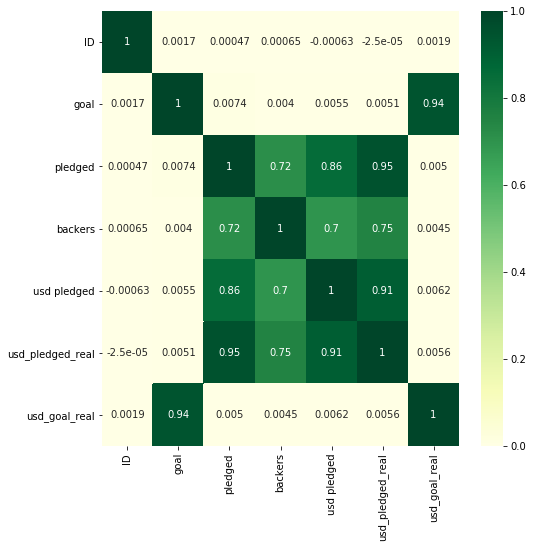

In [8]:
# heatmapに色付けて、相関性を確認
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr_data, cmap='YlGn', annot=True )
plt.show()

【調査結果】　概要判断
1. 使用するデータについては、"ks-projects-20180101"を用いる
   1. "ks-projects-201612"のデータは、"ks-projects-20180101"と比較して、未定義のコラム名（Unnamed～）がない。
   1. 未定義のコラムにおいては、多数の欠損値（NaN）が多数あるため。
     + 単純表示でも”ks-projects-201612”側は欠損値が多数表示さるため。

1. Crawd Founding(以降、CRFD）の各種登録データについて＜詳細確認は、次章で＞
  1. 欠損値の確認
  1. CR-FDの募金金額のデータ処理方法の検討 
  1. 日時データ（launch、deadline）の対処
  1. 国別データの確認
  1. 状態データ（state:成功/失敗etc.）の確認
*****

## 1.2 登録データの各項目、欠損などの確認
1. 利用するデータ（"ks-projects-20180101"）について、下記項目を確認し、対処方法などを決定する
  1. 欠損値の確認と、対処方法の検討
  1. CR-FDの募金金額のデータ精査と処理方法 
  1. 日時データ（launch、deadline）の対処
  1. 状態データ（state:成功/失敗etc.）の確認
  1. 国別データでのCRFDの実施<BR>
　　
1. 相関性の強いデータは、検討し、どちらか一方を採用などを検討
  1. CR-FDの募金金額データ(自国通貨データとUSD変換データ）
    + 統一性がある「USD変換データ」を使う予定であるが、平均/偏差/外れ値を確認する
  1. 国別データと国別通貨の相関性の確認について
    + 国別通貨（Currency）については、初回評価では採用しない（Drop）
    + （理由）銀行間送金を行えば、どの通貨でも換金可能（お金の募金であるため、他通貨を断るのはおかしい）

### A)欠損値の確認と対処方法

In [9]:
df_2018.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [10]:
name_nan = df_2018[df_2018['name'].isnull()]
display(name_nan)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.0,2012-01-01 12:35:31,100.0,failed,1,US,100.00,100.00,200000.00
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.0,2012-12-19 23:57:48,196.0,failed,12,GB,317.73,316.05,3224.97
309991,648853978,NaN,Product Design,Design,USD,2016-07-18,2500.0,2016-06-18 05:01:47,0.0,suspended,0,US,0.00,0.00,2500.00
338931,796533179,NaN,Painting,Art,USD,2011-12-05,35000.0,2011-11-06 23:55:55,220.0,failed,5,US,220.00,220.00,35000.00


In [11]:
usd_pld_nan = df_2018[df_2018['usd pledged'].isnull()]
display(usd_pld_nan.head(10))
display(usd_pld_nan.tail(10))

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",NaN,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00
824,1004013077,Spencer Capier Instrumental Project 2015,Music,Music,CAD,2014-10-10,4000.0,2014-09-10 22:51:01,4760.00,undefined,0,"N,0""",NaN,4251.14,3572.39
844,1004126342,LUKAS LIGETI'S 50TH BIRTHDAY FESTIVAL: ORIGINA...,Music,Music,USD,2015-06-11,5000.0,2015-05-15 02:12:35,6370.00,undefined,0,"N,0""",NaN,6370.00,5000.00
864,1004255433,The Battle For Breukelen: A Neighborhood Epic,Film & Video,Film & Video,USD,2015-11-07,6000.0,2015-10-10 18:45:24,6695.00,undefined,0,"N,0""",NaN,6695.00,6000.00
870,1004298993,"""Tamboura Plays Violin"" - a collection of Pop ...",Music,Music,USD,2015-03-28,2750.0,2015-02-11 19:28:27,2926.00,undefined,0,"N,0""",NaN,2926.00,2750.00
890,1004402863,Nightingale Noel - An A Cappella Holiday CD,Music,Music,USD,2015-12-11,1200.0,2015-11-11 21:02:55,1585.00,undefined,0,"N,0""",NaN,1585.00,1200.00


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
378011,996908566,The World Needs More Big Thinkers,Publishing,Publishing,USD,2015-09-13,8000.0,2015-07-30 03:01:31,0.00,undefined,0,"N,0""",NaN,0.00,8000.00
378100,99739483,No More Fear,Music,Music,GBP,2016-04-17,2500.0,2016-03-17 13:43:26,2500.00,undefined,0,"N,0""",NaN,3594.48,3594.48
378142,997554968,Susan Picking: Making Music with Kids in the S...,Music,Music,USD,2015-03-01,8000.0,2015-01-31 20:58:01,8582.00,undefined,0,"N,0""",NaN,8582.00,8000.00
378188,997793413,Whisper Violet - Honors Senior Thesis Film,Film & Video,Film & Video,USD,2016-05-14,2000.0,2016-04-14 01:27:27,2300.00,successful,0,"N,0""",NaN,2300.00,2000.00
378219,997915422,Otter's First Full Length Album,Music,Music,USD,2015-12-31,5000.0,2015-12-01 00:25:06,6065.26,undefined,0,"N,0""",NaN,6065.26,5000.00
378233,997971307,"EQUUS International Film Festival®, all-equine...",Film & Video,Film & Video,USD,2015-02-03,7500.0,2014-12-05 04:19:14,10.00,undefined,0,"N,0""",NaN,10.00,7500.00
378303,998319149,Emily 2050 - Short Film,Film & Video,Film & Video,CAD,2014-05-23,3000.0,2014-04-08 00:30:09,3102.00,undefined,0,"N,0""",NaN,2845.61,2752.04
378434,9988744,Matthew Stephens Music,Music,Music,USD,2016-02-05,5000.0,2016-01-06 21:59:23,235.00,undefined,0,"N,0""",NaN,235.00,5000.00
378585,999610349,Lady Vendredi: Afrofuturist concept 12 inch EP,Music,Music,GBP,2015-10-19,2000.0,2015-09-21 22:33:18,2125.00,undefined,0,"N,0""",NaN,3273.36,3080.81
378588,999621278,Jeune auteur a besoin de vous!,Publishing,Publishing,EUR,2015-11-20,1600.0,2015-10-21 21:28:13,0.00,undefined,0,"N,0""",NaN,0.00,1710.08


#### 【調査結果：A）欠損値】
1. 「name」の欠損値の取り扱い＝＞【修正編集】
   + 上記4点の「name」欠損値については、任意の「name(例：AAAなど」を補いデータ修正を行う
   + ＜理由＞他コラムのデータ値は「適切に登録されている」ため、「name」を補うことで利用できるデータのため
1. 「usd pledged」の欠損値の取り扱い＝＞【削除の方向で検討：Dropかデータ取り込み時で読み込まない】
   + UASの「pledge」の金額が「usd_pledged_readl」に等しく、かつ正しく記入されている
   + CAD(カナダ）、GBP（英国）などもあるが、正しく変化されていると考え「usd_pledged_readl」
      - 時期により、為替レートの変動があるため、国籍＝CADでも同一の返還レートとはならい。
1. ★【備忘録】
   + 「status(=undifined)」の場合に、「usd pledged」がNaNとなっている場合が多い
   + country=N.0" とは 

### B)募金金額データの精査と処理方法

In [12]:
display(df_2018.describe())

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


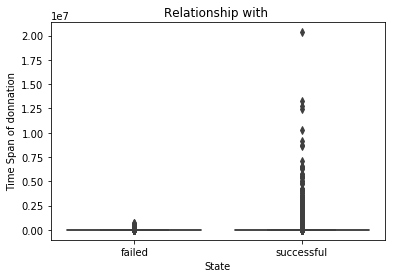

In [13]:
df_min_state =df_2018[ (df_2018['state'] == 'failed') |  (df_2018['state'] == 'successful') ]
#df_min_state =df[ df['state'] == 'failed']

#display(df_min_state.head())

box, ax = plt.subplots()
ax = sns.boxplot(x='state', y='usd_pledged_real', data=df_min_state)

ax.set_title('Relationship with ')
ax.set_xlabel('State')
ax.set_ylabel('Time Span of donnation')

plt.show()

### 【データ調査結果:B)募金金額データ】
### 各登録データ（説明変数の問題点）
+ １）概要データには、募金金額関係しか「数値データ」として表示されない
    + 時間データ(deadline/launcnedの日時)が、Object型のため」、Object型のため、変換が必要
+ ２）募金金額の「usd_pledge」,「usd_pledge_real」の差と、利用すべき”変数は”？　
    + 共に、ほぼ同一の金額が表示されている。相関性が極めて高い変数のため、調査の上、一方を使う。
+ ３）募金関連データの金額値が、範囲が広すぎるために【対数データ】化する
    + 四分位数のグラフを作成しても、”第一四分位、中央値、第三四分位”が「同一線」に成り、判断ができない
+ ４）★【備忘録】概要データには、募金金額関係しか「数値データ」として表示されない
    + 時間データ(deadline/launcnedの日時)が、Object型のため日時計算が簡易ではないために変換が必要

In [14]:
dupli = df_2018.duplicated(['usd pledged', 'usd_pledged_real']).value_counts()

#print(dupli)
print(dupli[0])
print(dupli[1])
print(df_2018.shape[0])

# 重複率
print('重複のパーセンテージ: {} %'.format(round (dupli[1] / ( dupli[0]+ dupli[1] ) * 100, 2) ))


146765
231896
378661
重複のパーセンテージ: 61.24 %


In [15]:
count1 = (df_2018['usd pledged']      == 0).sum()
count2 = (df_2018['usd_pledged_real'] == 0).sum()
count3 = (df_2018['usd pledged']      != 0).sum()
count4 = (df_2018['usd_pledged_real'] != 0).sum()


print("usd_pledged内の     「値＝０」の個数：{}".format(count1))
print("usd_pledged_real内の「値＝０」の個数：{}".format(count2))
print("usd_pledged内の     「値≠０」の個数：{}".format(count3))
print("usd_pledged_real内の「値≠０」の個数：{}".format(count4))
print()
print("usd_pledged内の     「項目数」の個数：{}".format(count1+count3))
print("usd_pledged_real内の「項目数」の個数：{}".format(count2+count4))

usd_pledged内の     「値＝０」の個数：68112
usd_pledged_real内の「値＝０」の個数：52527
usd_pledged内の     「値≠０」の個数：310549
usd_pledged_real内の「値≠０」の個数：326134

usd_pledged内の     「項目数」の個数：378661
usd_pledged_real内の「項目数」の個数：378661


In [16]:
num  = (df_2018['usd_pledged_real'] >= df_2018['usd pledged']).sum()
num_all =df_2018.shape[0]

# 比較率
print(num)
print(num_all)
print('募金金額の比較率（パーセンテージ）: {} %'.format( ( num /num_all) * 100) )
print('募金金額の比較率（パーセンテージ）: {} %'.format(round (  num /num_all * 100,3) ))



348532
378661
募金金額の比較率（パーセンテージ）: 92.04327881667244 %
募金金額の比較率（パーセンテージ）: 92.043 %


### B)クラウドファウンディングの「募金金額データ」の考察
1. 「金額データ」については、データ比較が簡単な「USDへの変化値」である「usd_**」側を使用する
1. goal(目標金額)は、「usd_goal_real」を用いる
1. pledged(支援金額)については、「usd_pledged_real」を用いる。
   1. ★(理由）「usd_pledged」と「usd_pledged_real」と極めて相関性が強いために、「**＿real」を使用
       - 重複率が61.4％であるが、”金額値＝０”が少なく、”金額値”は「**_real」側が高い        

### ★【修正】説明変数　(4/2)
1. usd_pledge、およびusd_pledge_realは利用しない（実際の募金金額のため）
1. また、支援者数も、募金終了後の支援者数であるため、利用しない（開始時には、支援者はいないため）

### C)国別データと国別通貨について
+ “currency（通貨）”と”country（国名）”は、Object型のため、簡単に相関が取れない
+ また、category,main_categoryにおいても、Object型のため、同様に相関が取れない

In [17]:
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [18]:
df_2018.corr()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
ID,1.000000,0.001679,0.000466,0.000654,-0.000633,-0.000025,0.001854
goal,0.001679,1.000000,0.007358,0.004012,0.005534,0.005104,0.942692
pledged,0.000466,0.007358,1.000000,0.717079,0.857370,0.952843,0.005024
backers,0.000654,0.004012,0.717079,1.000000,0.697426,0.752539,0.004517
usd pledged,-0.000633,0.005534,0.857370,0.697426,1.000000,0.907743,0.006172
usd_pledged_real,-0.000025,0.005104,0.952843,0.752539,0.907743,1.000000,0.005596
usd_goal_real,0.001854,0.942692,0.005024,0.004517,0.006172,0.005596,1.000000


## 【データ精査中断】
1. 複数のCRFDの金額データが不要と判明
   1. 新規に初期データを適切なコラムのみとして読み込み、メモリー消費を削減する
   1. 合わせて計算時間も短縮化できる 
1. データにおいて、相関が取れないものがあるため複数あるために、データ形式の変更が必要

## ３.「必要な選択項目」でのデータセット読み込み、データ項目と欠損などの確認・修正
1. 利用するデータ（"ks-projects-20180101"）について、下記項目を確認し、対処方法などを決定する
1. データを利用・利用しない（初期から読込まない）で、分類する
  1. ID  == 実際分類データID   　【利用しない：説明変数になりえない】
  1. name == CR-FDプロジェクト名 【利用しない：説明変数になりえない】
  1. categroy == 分類＜詳細＞カテゴリー名　　　　
  1. main_category == 分類テゴリー名　　　　　　　　　
  1. currency == CR-FDプロジェクトの実施国の通貨 　　
  1. deadline == 終了期日　　　　　　　　　　　　　　　
  1. goal  == 目標募集金額                    【利用しない:USD換金値を使用】  
  1. launched == プロジェクトの終了期日　　　　　　
  1. pledged == プロジェクトの募金金額の合計　　【利用しない:USD換金値を使用】  
  1. state         == プロジェクトの現状　　　　
  1. backer        == 支援者数                  　    【利用しない:終了後の結果値】  
  1. country       == プロジェクトの実施国名　
  1. usd_pledged      == USD換算の募金金額合計　　　　【利用しない:終了後の結果値】  
  1. usd_pledged_real == USD換算の募金金額の最終合計値【利用しない:終了後の結果値】  
  1. usd_goal_real    == USD換算の目標募金金額
---
1. 利用データ（読込みデータ）
  1. categroy      == 分類＜詳細＞カテゴリー名　　　　
  1. main_category == 分類テゴリー名　　　　　　　　　
  1. currency      == CR-FDプロジェクトの実施国の通貨 　　
  1. deadline      == 終了期日　　　　　　　　　　　　　　　
  1. launched 　　 == プロジェクトの終了期日　　　　　　
  1. state         == プロジェクトの現状　　　　
  1. country       == プロジェクトの実施国名　
  1. usd_goal_real    == USD換算の目標募金金額　
     + 右記の順で、読込む：main_categroy, category, state, launched, deadline, currency, country, usd_goal_real   　　　
  
1. 利用しないデータ（読込まないデータ）
  1. ID            　　　　　　　
  1. name           　　　　　　
  1. goal                             
  1. pledged       
  1. backer          
  1. usd_pledged
  1. usd_pledged_real 
---

1. 欠損値の確認と、対処方法の検討
  1. CR-FDの募金金額のデータ精査と処理方法~~ 
  1. 日時データ（launch、deadline）の対処
  1. 状態データ（state:成功/失敗etc.）の確認　
  1. 国別データでのCRFDの実施<BR>
　
1. 相関性の強いデータは、どちらか検討し、どちらか一方を採用
  1. CR-FDの募金金額データ(自国通貨データとUSD変換データ） 
  1. 国別データ（country）と国別通貨(currency)の相関性の確認
  1. カテゴリー（category）と主カテゴリー（Main_category)の相関性の確認  

In [19]:
df= pd.read_csv("../DATA/kickst/ks-projects-201801.csv")[['main_category', 'category', 'state', 'currency', 'country', \
                                                        'launched', 'deadline', 'usd_goal_real' ]]
display(df.head(10))

,main_category,category,state,currency,country,launched,deadline,usd_goal_real
0,Publishing,Poetry,failed,GBP,GB,2015-08-11 12:12:28,2015-10-09,1533.95
1,Film & Video,Narrative Film,failed,USD,US,2017-09-02 04:43:57,2017-11-01,30000.00
2,Film & Video,Narrative Film,failed,USD,US,2013-01-12 00:20:50,2013-02-26,45000.00
3,Music,Music,failed,USD,US,2012-03-17 03:24:11,2012-04-16,5000.00
4,Film & Video,Film & Video,canceled,USD,US,2015-07-04 08:35:03,2015-08-29,19500.00
5,Food,Restaurants,successful,USD,US,2016-02-26 13:38:27,2016-04-01,50000.00
6,Food,Food,successful,USD,US,2014-12-01 18:30:44,2014-12-21,1000.00
7,Food,Drinks,failed,USD,US,2016-02-01 20:05:12,2016-03-17,25000.00
8,Design,Product Design,canceled,USD,US,2014-04-24 18:14:43,2014-05-29,125000.00
9,Film & Video,Documentary,canceled,USD,US,2014-07-11 21:55:48,2014-08-10,65000.00


In [20]:
df.tail()

,main_category,category,state,currency,country,launched,deadline,usd_goal_real
378656,Film & Video,Documentary,canceled,USD,US,2014-09-17 02:35:30,2014-10-17,50000.0
378657,Film & Video,Narrative Film,failed,USD,US,2011-06-22 03:35:14,2011-07-19,1500.0
378658,Film & Video,Narrative Film,failed,USD,US,2010-07-01 19:40:30,2010-08-16,15000.0
378659,Technology,Technology,failed,USD,US,2016-01-13 18:13:53,2016-02-13,15000.0
378660,Art,Performance Art,failed,USD,US,2011-07-19 09:07:47,2011-08-16,2000.0


### A）欠損値の対応 (4/2: nameの欠損値修正は不要)
* 確認と修正
  + 「name」の欠損値を再確認し、任意の名前を入れ込み修正し、「適切データ」として再利用する 
   - ID = 166851, Category= Film & Video  ==> AAA  
   - ID = 307234, Category= Games         ==> BBB　
   - ID = 309991, Category= Design        ==> CCC
   - ID = 338931, Category= Art           ==> DDD
   
#### 【追加対処】
* nameは、CR-FDの成功・失敗には、直接影響しないデータ名のため、使用しないこととした。
  + 初期読み込み時点において、読込まないために、nameへの欠損値処置は、不要となった

In [133]:
'''
name_nan = df[df['name'].isnull()]
display(name_nan)
name_nan_list = name_nan.index
print(name_nan_list)
'''

"\nname_nan = df[df['name'].isnull()]\ndisplay(name_nan)\nname_nan_list = name_nan.index\nprint(name_nan_list)\n"

In [ ]:
print(df['name'].loc[name_nan_list])
df['name'].loc[name_nan_list[0]] = 'AAA'
df['name'].loc[name_nan_list[1]] = 'BBB'
df['name'].loc[name_nan_list[2]] = 'CCC'
df['name'].loc[name_nan_list[3]] = 'DDD'

display(df.loc[name_nan_list])

In [ ]:
#変数の確認と欠損値
print(df.info())
print(df.isnull().sum())

### 【欠損値修正】
~~「name」における欠損値（4項目）は、正しく修正完了　（削除のため、修正が不要であった）~~
~~数的にも、全項目が”378,661”である適切なデータとなった~~
~~CRFDの金額データ内の欠損値も、読み込み時点での処置完了~~

### B）CRFDの金額データの対数化
* 募金関連データの金額値が、範囲が広すぎるために「対数データ」化する
  + 四分位数のグラフを作成しても、”第一四分位、中央値、第三四分位”が「同一線」に成り、判断ができない

In [22]:
df.describe()

,usd_goal_real
count,3.786610e+05
mean,4.545440e+04
std,1.152950e+06
min,1.000000e-02
25%,2.000000e+03
50%,5.500000e+03
75%,1.550000e+04
max,1.663614e+08


In [23]:
#df['usd pledged log'] = np.log10(df['usd pledged'] + 1.0)
#df['usd_pledged_real_log'] = np.log10(df['usd_pledged_real'] +1.0)
df['usd_goal_real_log'] = np.log10(df['usd_goal_real'] +1.0)

In [24]:
df.describe()

,usd_goal_real,usd_goal_real_log
count,3.786610e+05,378661.000000
mean,4.545440e+04,3.750910
std,1.152950e+06,0.734568
min,1.000000e-02,0.004321
25%,2.000000e+03,3.301247
50%,5.500000e+03,3.740442
75%,1.550000e+04,4.190360
max,1.663614e+08,8.221053


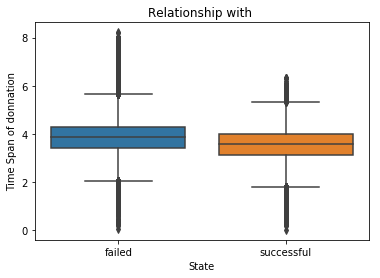

In [25]:
df_min_state =df[ (df['state'] == 'failed') |  (df['state'] == 'successful') ]
#df_min_state =df[ df['state'] == 'failed']

#display(df_min_state.head())

box, ax = plt.subplots()
ax = sns.boxplot(x='state', y='usd_goal_real_log', data=df_min_state)

ax.set_title('Relationship with ')
ax.set_xlabel('State')
ax.set_ylabel('Time Span of donnation')

plt.show()

### 【考察】
+ 1)対数化によって、金額データの四分位数グラフで状況がわかる「変数」となった。
+ 2)失敗／成功は、金額の差により「違いがわかる状態」になった。
+ 3)★【備忘録】評価時のモデル作成時においては、成功データから金額値の±３σのデータを削除する場合も検討

In [26]:
df_new = df.drop(columns=['usd_goal_real'])
df_new.head()

,main_category,category,state,currency,country,launched,deadline,usd_goal_real_log
0,Publishing,Poetry,failed,GBP,GB,2015-08-11 12:12:28,2015-10-09,3.186094
1,Film & Video,Narrative Film,failed,USD,US,2017-09-02 04:43:57,2017-11-01,4.477136
2,Film & Video,Narrative Film,failed,USD,US,2013-01-12 00:20:50,2013-02-26,4.653222
3,Music,Music,failed,USD,US,2012-03-17 03:24:11,2012-04-16,3.699057
4,Film & Video,Film & Video,canceled,USD,US,2015-07-04 08:35:03,2015-08-29,4.290057


### C）日時データの対処
+ launched （日付＋時間）、deadline（日付のみ）はObject型のため、datetime64へする
  - 日付表示に統一する（★同データは、募金の開始国での開始・終了と考え、時差の修正は行わない）
+ deadline - launched から、募金期間（ 単位日）を求め、これを「Diff=>Day」利用する説明変数とする

In [27]:
#日時データ変数の確認 
#print(df.info())
df_new['launched'] = pd.to_datetime(df_new['launched'])
df_new['deadline'] = pd.to_datetime(df_new['deadline'])
df_new['diff'] = df_new['deadline'] - df_new['launched']
print(df_new.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 9 columns):
main_category        378661 non-null object
category             378661 non-null object
state                378661 non-null object
currency             378661 non-null object
country              378661 non-null object
launched             378661 non-null datetime64[ns]
deadline             378661 non-null datetime64[ns]
usd_goal_real_log    378661 non-null float64
diff                 378661 non-null timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), object(5), timedelta64[ns](1)
memory usage: 26.0+ MB
None


In [28]:
#日時データ変数の確認 
display(df_new.head())

,main_category,category,state,currency,country,launched,deadline,usd_goal_real_log,diff
0,Publishing,Poetry,failed,GBP,GB,2015-08-11 12:12:28,2015-10-09,3.186094,58 days 11:47:32
1,Film & Video,Narrative Film,failed,USD,US,2017-09-02 04:43:57,2017-11-01,4.477136,59 days 19:16:03
2,Film & Video,Narrative Film,failed,USD,US,2013-01-12 00:20:50,2013-02-26,4.653222,44 days 23:39:10
3,Music,Music,failed,USD,US,2012-03-17 03:24:11,2012-04-16,3.699057,29 days 20:35:49
4,Film & Video,Film & Video,canceled,USD,US,2015-07-04 08:35:03,2015-08-29,4.290057,55 days 15:24:57


In [29]:
# 追加修正：launchedデータから「日付け」の抽出
data0 = df_new['launched'][0]
print(data0)
print(data0.date())

# 追加修正：Diffデータから「日数」の抽出
data1 = df_new['diff'][0]
print(data1)
print(data1.days)

2015-08-11 12:12:28
2015-08-11
58 days 11:47:32
58


In [30]:
# CRFD日数の計算
#launched から「日付のみ」の表示に変更
df_new['launched'] = df_new['launched'].dt.date
df_new['launched'] = pd.to_datetime(df_new['launched'])

# Head(), tail()確認より、「時間の端数」について、１日プラスの切り上げを行う
df_new['days'] = df_new['diff'].dt.days +1
display(df_new.head())

,main_category,category,state,currency,country,launched,deadline,usd_goal_real_log,diff,days
0,Publishing,Poetry,failed,GBP,GB,2015-08-11,2015-10-09,3.186094,58 days 11:47:32,59
1,Film & Video,Narrative Film,failed,USD,US,2017-09-02,2017-11-01,4.477136,59 days 19:16:03,60
2,Film & Video,Narrative Film,failed,USD,US,2013-01-12,2013-02-26,4.653222,44 days 23:39:10,45
3,Music,Music,failed,USD,US,2012-03-17,2012-04-16,3.699057,29 days 20:35:49,30
4,Film & Video,Film & Video,canceled,USD,US,2015-07-04,2015-08-29,4.290057,55 days 15:24:57,56


In [31]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 10 columns):
main_category        378661 non-null object
category             378661 non-null object
state                378661 non-null object
currency             378661 non-null object
country              378661 non-null object
launched             378661 non-null datetime64[ns]
deadline             378661 non-null datetime64[ns]
usd_goal_real_log    378661 non-null float64
diff                 378661 non-null timedelta64[ns]
days                 378661 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(1), object(5), timedelta64[ns](1)
memory usage: 28.9+ MB


*****
### D）状態データ（state:成功/失敗etc.）の確認とDataFrameへの処置
1. 目的変数
   + Stateには下記の様に複数属性があり、これら内容で分類し、検討する必要あり。
     - successful, failed, canceled, (etc. ?)
     - ★【備忘録】初回は、「成功、失敗」の２値で考察
1. 「成功・失敗」でのDataFrameを再構成する 
1. ★【備忘録】
   + 方法１）canceledなどと入れた多値分類を検討すべきか
   + 方法２）canceledなど、その他は、「failed」に組み込み検討すべきか


In [32]:
Status = df_new['state'].unique()
print(Status)

Status_count = df_new['state'].value_counts()
print(Status_count)
print(type(Status_count))

df_status = pd.DataFrame({'count':Status_count})
df_status = df_status.reset_index()
df_status = df_status.rename(columns={'index':'status'})
display(df_status)


df_status['ratio'] = df_status['count'] / df.shape[0] *100
display(df_status)

['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']
failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64
<class 'pandas.core.series.Series'>


,status,count
0,failed,197719
1,successful,133956
2,canceled,38779
3,undefined,3562
4,live,2799
5,suspended,1846


,status,count,ratio
0,failed,197719,52.215306
1,successful,133956,35.376234
2,canceled,38779,10.241086
3,undefined,3562,0.940683
4,live,2799,0.739184
5,suspended,1846,0.487507


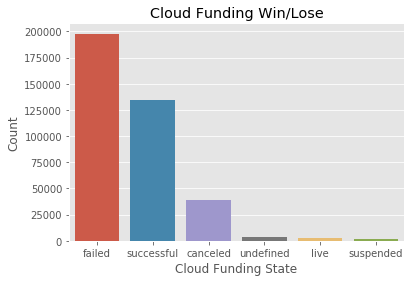

In [33]:
#fig = plt.figure(figsize=(6, 6))

plt.style.use('ggplot')
ax1 = fig.add_subplot
ax1 = sns.countplot('state', data=df, order=df_new['state'].value_counts().index)

ax1.set_title('Cloud Funding Win/Lose')
ax1.set_xlabel('Cloud Funding State')
ax1.set_ylabel('Count')


plt.show()

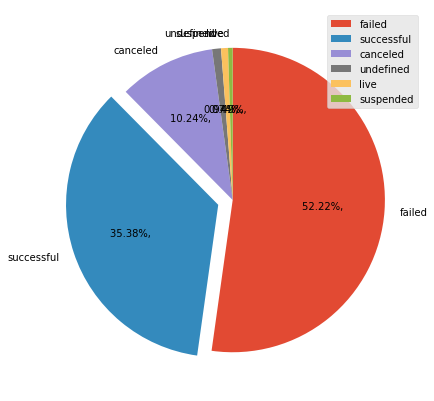

In [34]:

fig = plt.figure(figsize=(7, 7))

Status_ratio = df_status['ratio']
Count = df_status['status']
ex = [0, 0.1, 0, 0, 0, 0]
plt.pie(Status_ratio, labels= Count, explode= ex, \
        counterclock= False, startangle=90, autopct='%1.2f%%, '  )
plt.legend(loc='upper right')

plt.show()

### クラウドファウンディング（CR-FD）の最終状態について
【簡易考察】
+ １）live,undefined,suspendは、データ個数より無視する
   - 事業を開始するために「CR-FD」を開始したが、成功・失敗に分類できなたいめに、データから除外する  
+ ２）Cancelについては、時間があれば考察して、取り扱いを明確にする
   - 何らかの理由より、「CR-FD」を途中終了しため、原因を考える必要がある
   - データ解析分類A）では無視（2値で解析）、データ解析分類B)では組み入れ（３値で解析）を考える
+ ３）初回は、Failed・Successfulについて、2値分類を考える

### D2)DataFrameの適正化
+ 1）State=Failed/Successfulによって、DFを削減する
+ 2）CR-FD募集期間（days)を残し、計算式の元になったデータ(launched, deadline, diff）を削除し、FataFrameを整理

In [35]:
df_st =df_new[ (df_new['state'] == 'failed') |  (df_new['state'] == 'successful') ]

display(df_st.head())
print(df_st['state'].unique())

,main_category,category,state,currency,country,launched,deadline,usd_goal_real_log,diff,days
0,Publishing,Poetry,failed,GBP,GB,2015-08-11,2015-10-09,3.186094,58 days 11:47:32,59
1,Film & Video,Narrative Film,failed,USD,US,2017-09-02,2017-11-01,4.477136,59 days 19:16:03,60
2,Film & Video,Narrative Film,failed,USD,US,2013-01-12,2013-02-26,4.653222,44 days 23:39:10,45
3,Music,Music,failed,USD,US,2012-03-17,2012-04-16,3.699057,29 days 20:35:49,30
5,Food,Restaurants,successful,USD,US,2016-02-26,2016-04-01,4.698979,34 days 10:21:33,35


['failed' 'successful']


In [36]:
# ２）不要な日時系データ（コラムの削除）
df_st = df_st.drop(['launched', 'deadline', 'diff'], axis=1)

display(df_st.head())

,main_category,category,state,currency,country,usd_goal_real_log,days
0,Publishing,Poetry,failed,GBP,GB,3.186094,59
1,Film & Video,Narrative Film,failed,USD,US,4.477136,60
2,Film & Video,Narrative Film,failed,USD,US,4.653222,45
3,Music,Music,failed,USD,US,3.699057,30
5,Food,Restaurants,successful,USD,US,4.698979,35


### E）Object型データ対処と相関性の確認、DataFrameへの処置
1. 下記目的変数を"Object型"から、"Category型"に変更
  1. 国別データ（country）と国別通貨(currency)
  1. カテゴリー（category）と主カテゴリー（Main_category)<BR>

1. DataFrameに各値の"Category型"のコラム追加
1. 各説明変数の相関を取り、評価の利用する変数を決定する



### E1)国名（country）と通貨（curency）の調査
* 一見しただけで、強い相関性があると思われる。
* Euroの利用を利用している国のために、若干相関が薄れるが、USA/USD, GB/GBP,CA/CAD,などと比べ桁が違う。
* CurrencyとCountryの「1文字目、2文字目」で比較し、相関状態を調べる 
  + EUを用いる国を、データすると明らかな相関が明確化できると考える。
  + ヨーロッパでEuro使用の国
     - ドイツ＝DE、フランス＝FR、オランダ＝NL、イタリア＝IT、スペイン＝ES、スウェーデン＝SE
     - アイルランド＝IE、ベルギー＝BE、オーストリア＝AT、ルクセンブルグ＝LU
  + ヨーロッパでEuro未使用の国
    - イギリス＝GB（GBP）、スウェーデン＝SE（SEK)、デンマーク＝DK（DKK)、スイス＝CH（CHF)、ノルウェー＝NL(NLK)、
    
* 他の自国通貨利用の国名
    + アメリカ＝US（USB）、カナダ＝CA（CAD)、オーストラリアAU（AUD）、ニュージーランド＝NZ（NLD）、メキシコ＝MX（MXN)、
    + 香港＝HK（HKD）、シンガポール＝SG(SGD)、日本＝JP（JPY)

In [37]:
df_st['country'].value_counts()

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

In [38]:
df_st['currency'].value_counts()

USD    261511
GBP     29476
EUR     14378
CAD     12375
AUD      6621
SEK      1510
MXN      1411
NZD      1274
DKK       929
CHF       652
NOK       584
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64

In [39]:
df_cc = df_st[ df_st['country'].str[:2] != df_st['currency'].str[:2] ]

In [40]:
display(df_cc.head(10))
display(df_cc.tail(10))

,main_category,category,state,currency,country,usd_goal_real_log,days
61,Fashion,Accessories,failed,EUR,IT,4.120684,30
86,Publishing,Publishing,failed,EUR,DE,4.045088,60
90,Games,Tabletop Games,successful,EUR,IT,3.773751,30
133,Technology,Software,failed,EUR,IE,3.659785,30
157,Film & Video,Action,failed,EUR,ES,2.061716,60
211,Fashion,Apparel,successful,EUR,FR,3.535746,30
213,Art,Performance Art,failed,EUR,FR,2.917726,60
268,Fashion,Fashion,successful,EUR,DE,3.352532,16
269,Fashion,Accessories,failed,EUR,DE,4.046729,42
270,Design,Product Design,failed,EUR,FR,4.796412,46


,main_category,category,state,currency,country,usd_goal_real_log,days
378428,Music,Music,failed,EUR,FR,5.055383,60
378447,Music,Music,failed,EUR,IT,5.046423,21
378474,Art,Public Art,failed,EUR,DE,4.126644,30
378519,Journalism,Web,failed,EUR,DE,5.052119,30
378551,Photography,Photobooks,failed,EUR,NL,4.467699,30
378563,Games,Video Games,failed,EUR,ES,4.215414,30
378568,Technology,Technology,failed,EUR,DE,5.642147,35
378627,Photography,Fine Art,failed,EUR,FR,3.738464,15
378630,Art,Illustration,successful,EUR,NL,3.229579,30
378642,Games,Tabletop Games,successful,EUR,FR,3.066959,27


In [41]:
# CountryとCurrecyには、強い同一性（相関）があり、違う場合は、Euroを使う場合と考えられる
# CR-CFの成功/失敗の個数
len_st = df_st.shape[0]
len_cc = df_cc.shape[0]
#print(len_df_st)
#print(len_cc)

#相関性の確認 (Euro利用を除いた場合での、)
Cor = (len_st - len_cc)/len_st 
print("通貨と国名の相関性 = {:.3f}%".format(Cor))

通貨と国名の相関性 = 0.956%


### 通貨と国名では、相関性が強いために、「国名のみ」を説明変数として利用する
---
主カテゴリ・カテゴリの調査

In [42]:
df_st['main_category'].value_counts()

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

In [43]:
df_st['category'].value_counts()[0:20]

Product Design      18680
Documentary         14523
Music               12633
Tabletop Games      11744
Shorts              11394
Food                10416
Video Games          9328
Film & Video         8624
Fiction              8108
Fashion              7529
Art                  7486
Nonfiction           7414
Theater              6684
Rock                 6246
Children's Books     6198
Apparel              6166
Technology           5726
Indie Rock           5329
Apps                 5287
Photography          5246
Name: category, dtype: int64

In [44]:
print(df_st['category'].value_counts()[-20:])
print(df_st['category'].unique())

Video Art          174
Photo              169
Knitting           164
Romance            163
Crochet            151
Workshops          148
Translations       137
Glass              122
Latin              121
Pet Fashion        119
Embroidery         100
Typography          97
Pottery             88
Weaving             82
Quilts              75
Residencies         68
Letterpress         46
Chiptune            33
Literary Spaces     19
Taxidermy           10
Name: category, dtype: int64
['Poetry' 'Narrative Film' 'Music' 'Restaurants' 'Food' 'Drinks'
 'Nonfiction' 'Indie Rock' 'Crafts' 'Games' 'Tabletop Games' 'Design'
 'Comic Books' 'Art Books' 'Fashion' 'Childrenswear' 'Theater' 'Comics'
 'DIY' 'Webseries' 'Animation' 'Food Trucks' 'Product Design' 'Public Art'
 'Documentary' 'Illustration' 'Photography' 'Pop' 'People' 'Art' 'Family'
 'Fiction' 'Film & Video' 'Accessories' 'Rock' 'Hardware' 'Software'
 'Weaving' 'Web' 'Jazz' 'Ready-to-wear' 'Festivals' 'Video Games'
 'Anthologies' 'Publ

### カテゴリの対応
+ メインカテゴリを用いる
    - これらも強い相関性を持つデータのため
    - カテゴリでは、細分化され過ぎている。 細分化下位のカテゴリでは、サンプル数が少なすぎる  

In [45]:
df_st.info()
#1)カテゴリ型への変換
df_st['country'] = df_st['country'].astype('category')
df_st['currency'] = df_st['currency'].astype('category')

df_st['category'] = df_st['category'].astype('category')
df_st['main_category'] = df_st['main_category'].astype('category')

df_st.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 7 columns):
main_category        331675 non-null object
category             331675 non-null object
state                331675 non-null object
currency             331675 non-null object
country              331675 non-null object
usd_goal_real_log    331675 non-null float64
days                 331675 non-null int64
dtypes: float64(1), int64(1), object(5)
memory usage: 20.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 7 columns):
main_category        331675 non-null category
category             331675 non-null category
state                331675 non-null object
currency             331675 non-null category
country              331675 non-null category
usd_goal_real_log    331675 non-null float64
days                 331675 non-null int64
dtypes: category(4), float64(1), int64(1), object(1)
memory usage: 11.7+ MB


In [46]:
# 2)4変数のDataFrameへの追加
df_st['country_cat'] = df_st.country.cat.codes
df_st['currency_cat'] = df_st.currency.cat.codes

df_st['category_cat'] = df_st.category.cat.codes
df_st['main_category_cat'] = df_st.main_category.cat.codes

display(df_st.head())
print(df_st.info())


,main_category,category,state,currency,country,usd_goal_real_log,days,country_cat,currency_cat,category_cat,main_category_cat
0,Publishing,Poetry,failed,GBP,GB,3.186094,59,9,5,108,12
1,Film & Video,Narrative Film,failed,USD,US,4.477136,60,22,13,93,6
2,Film & Video,Narrative Film,failed,USD,US,4.653222,45,22,13,93,6
3,Music,Music,failed,USD,US,3.699057,30,22,13,90,10
5,Food,Restaurants,successful,USD,US,4.698979,35,22,13,123,7


<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 11 columns):
main_category        331675 non-null category
category             331675 non-null category
state                331675 non-null object
currency             331675 non-null category
country              331675 non-null category
usd_goal_real_log    331675 non-null float64
days                 331675 non-null int64
country_cat          331675 non-null int8
currency_cat         331675 non-null int8
category_cat         331675 non-null int16
main_category_cat    331675 non-null int8
dtypes: category(4), float64(1), int16(1), int64(1), int8(3), object(1)
memory usage: 13.3+ MB
None


### 【考察】
+ 国名（country）と国別通貨（currency）の相関性が高いため、”country”のみを利用する。
+ 主カテゴリと、カテゴリも相関性が高いために、また細分類の場合には、

## ４.最終的DataFrameへの成形
+ DataFrame"df_st" から、削除する説明変数
  - main_category, category => 　数値型のダミー変数：main_category_catを用いる
  - category_cat => 　  同上 
  - counrty, currency => 　数値型のダミー変数：countrt_catを用いる
  - currency_cat =>     同上
 

In [47]:
df_st.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 11 columns):
main_category        331675 non-null category
category             331675 non-null category
state                331675 non-null object
currency             331675 non-null category
country              331675 non-null category
usd_goal_real_log    331675 non-null float64
days                 331675 non-null int64
country_cat          331675 non-null int8
currency_cat         331675 non-null int8
category_cat         331675 non-null int16
main_category_cat    331675 non-null int8
dtypes: category(4), float64(1), int16(1), int64(1), int8(3), object(1)
memory usage: 13.3+ MB


In [48]:
#df_F = df_st.drop(['ID','name','category','main_category','country','currency','diff','currency_cat'], axis=1)
df_F = df_st.drop(['main_category', 'category','currency', 'country','currency_cat'], axis=1)
df_F.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 6 columns):
state                331675 non-null object
usd_goal_real_log    331675 non-null float64
days                 331675 non-null int64
country_cat          331675 non-null int8
category_cat         331675 non-null int16
main_category_cat    331675 non-null int8
dtypes: float64(1), int16(1), int64(1), int8(2), object(1)
memory usage: 11.4+ MB


In [49]:
#df_F = df_st.drop(['ID','name','category','main_category','country','currency','diff','currency_cat'], axis=1)
df_F2 = df_st.drop(['main_category', 'category','currency', 'country','currency_cat','category_cat'], axis=1)
df_F2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 5 columns):
state                331675 non-null object
usd_goal_real_log    331675 non-null float64
days                 331675 non-null int64
country_cat          331675 non-null int8
main_category_cat    331675 non-null int8
dtypes: float64(1), int64(1), int8(2), object(1)
memory usage: 10.8+ MB


*****
## 5.ロジスティック回帰での学習と評価
### 5.1 主カテゴリとカテゴリを利用 => df_F, 5説明変数

In [50]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score,precision_recall_fscore_support, confusion_matrix

In [51]:
y = df_F['state'].values
X = df_F.drop(['state'], axis=1).values

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol= 1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]

print('w0= {:.3f}, w1= {:.3f}, w2= {:.3f}, w3= {:.3f}, w4= {:.3f}, w5= {:.3f}'.format(w0, w1, w2, w3, w4, w5) )

w0= 2.485, w1= -0.777, w2= -0.007, w3= 0.020, w4= 0.001, w5= -0.021


In [52]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 61.530%
適合率（Precision） = 64.306%
再現率（Recall） = 79.708%
F1値（F1-score） = 71.184%


In [53]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = CR-FD 成功', '正解 = CR－FD失敗'], 
                        columns=['予測 = CR-FD成功', '予測 = CR-FD失敗'])
conf_mat

,予測 = CR-FD成功,予測 = CR-FD失敗
正解 = CR-FD 成功,157598,40121
正解 = CR－FD失敗,87476,46480


### 5.2 主カテゴリのみを利用　=> df_F2, 4説明変数

In [54]:
y = df_F2['state'].values
X = df_F2.drop(['state'], axis=1).values

clf2 = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol= 1e-3)
clf2.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]

print('w0= {:.3f}, w1= {:.3f}, w2= {:.3f}, w3= {:.3f}, w4= {:.3f}'.format(w0, w1, w2, w3, w4) )

w0= 2.485, w1= -0.777, w2= -0.007, w3= 0.020, w4= 0.001


In [55]:
# ラベルを予測
y_pred2 = clf2.predict(X)

# 正答率を計算
accuracy2 =  accuracy_score(y, y_pred2)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy2))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred2)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 61.154%
適合率（Precision） = 61.855%
再現率（Recall） = 90.875%
F1値（F1-score） = 73.608%


In [56]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = CR-FD 成功', '正解 = CR－FD失敗'], 
                        columns=['予測 = CR-FD成功', '予測 = CR-FD失敗'])
conf_mat

,予測 = CR-FD成功,予測 = CR-FD失敗
正解 = CR-FD 成功,157598,40121
正解 = CR－FD失敗,87476,46480


### 5.3 カテゴリ(詳細）のみを利用　=> df_F3, 4説明変数 

In [57]:
#df_F = df_st.drop(['ID','name','category','main_category','country','currency','diff','currency_cat'], axis=1)
df_F3 = df_st.drop(['main_category', 'category','currency', 'country','currency_cat', 'main_category_cat'], axis=1)
df_F3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 5 columns):
state                331675 non-null object
usd_goal_real_log    331675 non-null float64
days                 331675 non-null int64
country_cat          331675 non-null int8
category_cat         331675 non-null int16
dtypes: float64(1), int16(1), int64(1), int8(1), object(1)
memory usage: 11.1+ MB


In [58]:
y = df_F3['state'].values
X = df_F3.drop(['state'], axis=1).values

clf3 = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol= 1e-3)
clf3.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]

print('w0= {:.3f}, w1= {:.3f}, w2= {:.3f}, w3= {:.3f}, w4= {:.3f}'.format(w0, w1, w2, w3, w4) )

w0= 2.485, w1= -0.777, w2= -0.007, w3= 0.020, w4= 0.001


In [59]:
# ラベルを予測
y_pred3 = clf3.predict(X)

# 正答率を計算
accuracy3 =  accuracy_score(y, y_pred3)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy3))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred3)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 61.504%
適合率（Precision） = 63.965%
再現率（Recall） = 81.128%
F1値（F1-score） = 71.531%


In [60]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = CR-FD 成功', '正解 = CR－FD失敗'], 
                        columns=['予測 = CR-FD成功', '予測 = CR-FD失敗'])
conf_mat

,予測 = CR-FD成功,予測 = CR-FD失敗
正解 = CR-FD 成功,157598,40121
正解 = CR－FD失敗,87476,46480


### 【考察】　主カテゴリ・カテゴリについて
* 結果より、主カテゴリとカテゴリの両方を説明変数として利用する
---
## 6.ホールドアウト法、交差検証法での比較確認
1. ホールドアウト法（Train：80％、Test：20％）に分割して、確認する
1. 交差検証法（K=10）
  +  上記の場合には、主カテゴリ・カテゴリの両説明変数を用いる
  
### 6.1 ホールドアウト法 

In [61]:
df_F.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 6 columns):
state                331675 non-null object
usd_goal_real_log    331675 non-null float64
days                 331675 non-null int64
country_cat          331675 non-null int8
category_cat         331675 non-null int16
main_category_cat    331675 non-null int8
dtypes: float64(1), int16(1), int64(1), int8(2), object(1)
memory usage: 11.4+ MB


In [62]:
# 説明変数と目的変数の分離（Trainデータと、Testデータ分割）
df_F_data = df_F.drop("state", axis=1)
df_F_label = df_F["state"]

#確認
display(df_F_data.head(3))
display(df_F_label.head(3))

,usd_goal_real_log,days,country_cat,category_cat,main_category_cat
0,3.186094,59,9,108,12
1,4.477136,60,22,93,6
2,4.653222,45,22,93,6


0    failed
1    failed
2    failed
Name: state, dtype: object

In [63]:
print(df_F_data.shape)
print(df_F_label.shape)

(331675, 5)
(331675,)


In [64]:
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    df_F_data, df_F_label, test_size=0.2, random_state=1234)

In [66]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
ratio = y_test.shape[0]/ ( y_train.shape[0] + y_test.shape[0] )
print("test_size= {}".format(ratio))

(265340, 5) (265340,)
(66335, 5) (66335,)
test_size= 0.2


In [67]:
#y = df_F['state'].values
#X = df_F.drop(['state'], axis=1).values

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol= 1e-3)
clf.fit(X_train, y_train)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]

print('w0= {:.3f}, w1= {:.3f}, w2= {:.3f}, w3= {:.3f}, w4= {:.3f}, w5= {:.3f}'.format(w0, w1, w2, w3, w4, w5) )

w0= 2.545, w1= -0.811, w2= -0.029, w3= 0.016, w4= -0.007, w5= -0.014


In [68]:
# ラベルを予測
y_pred = clf.predict(X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 60.247%
適合率（Precision） = 60.239%
再現率（Recall） = 98.908%
F1値（F1-score） = 74.876%


In [69]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = CR-FD 成功', '正解 = CR－FD失敗'], 
                        columns=['予測 = CR-FD成功', '予測 = CR-FD失敗'])
conf_mat

,予測 = CR-FD成功,予測 = CR-FD失敗
正解 = CR-FD 成功,39294,434
正解 = CR－FD失敗,25936,671


### 6.1 B) Stratified Split

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    df_F_data, df_F_label, test_size=0.2, random_state=1234, stratify=df_F_label)

In [71]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
ratio = y_test.shape[0]/ ( y_train.shape[0] + y_test.shape[0] )
print("test_size= {}".format(ratio))

(265340, 5) (265340,)
(66335, 5) (66335,)
test_size= 0.2


In [72]:
#y = df_F['state'].values
#X = df_F.drop(['state'], axis=1).values

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol= 1e-3)
clf.fit(X_train, y_train)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]

print('w0= {:.3f}, w1= {:.3f}, w2= {:.3f}, w3= {:.3f}, w4= {:.3f}, w5= {:.3f}'.format(w0, w1, w2, w3, w4, w5) )

w0= 2.548, w1= -0.794, w2= -0.022, w3= 0.025, w4= 0.004, w5= 0.000


In [73]:
# ラベルを予測
y_pred = clf.predict(X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 61.618%
適合率（Precision） = 64.721%
再現率（Recall） = 78.287%
F1値（F1-score） = 70.861%


In [74]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = CR-FD 成功', '正解 = CR－FD失敗'], 
                        columns=['予測 = CR-FD成功', '予測 = CR-FD失敗'])
conf_mat

,予測 = CR-FD成功,予測 = CR-FD失敗
正解 = CR-FD 成功,30958,8586
正解 = CR－FD失敗,16875,9916


### 【考察】データ分割が重要である
 + データ分割を「ホールドアウト法」から、「層化的抽出（引数＝Strtifty）」に変更することで、正答率が約1.5%上昇
 https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
----
### 6.2 交差検証法: KFold （ｋ＝５）

In [75]:
# 各変数の設定や初期化
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_accuracy  = 0
cross_valid_precision = 0
cross_valid_recall    = 0
cross_valid_f1_score  = 0

split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(df_F_data, df_F_label):
    X_train, y_train = df_F_data.iloc[train_idx], df_F_label.iloc[train_idx] #学習用データ
    X_test, y_test = df_F_data.iloc[test_idx], df_F_label.iloc[test_idx]     #テスト用データ
    
    # 学習用データを使って確率勾配法での分類
    clf_kf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol= 1e-3)
    clf_kf.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred = clf_kf.predict(X_test)

    # 正答率を計算
    accuracy =  accuracy_score(y_test, y_pred)
    print('【Cross_Valid {}回目】'.format(split_num))
    print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

    # Precision, Recall, F1-scoreを計算
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

    # カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
    print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
    print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
    print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
    print()
    
    cross_valid_accuracy += accuracy
    cross_valid_precision += (100 * precision[0])
    cross_valid_recall += (100 * recall[0])
    cross_valid_f1_score += (100 * f1_score[0])
    
    split_num += 1

# 各値の全体平均
Mean_accuracy  = cross_valid_accuracy  / n_split
Mean_precision = cross_valid_precision / n_split
Mean_recall    = cross_valid_recall    / n_split
Mean_f1_score  = cross_valid_f1_score  / n_split

# 正答率を計算
print('【Cross_Valid 全体平均】')
print('Cross_Valid平均 正答率（Accuracy） = {:.3f}%'.format(100 * Mean_accuracy ))

# Precision, Recall, F1-scoreを表示
print('Cross_Valid平均 適合率（Precision） = {:.3f}%'.format( 100 * Mean_precision ))
print('Cross_Valid平均 再現率（Recall） = {:.3f}%'.format(100 *     Mean_recall))
print('Cross_Valid平均 F1値（F1-score） = {:.3f}%'.format(100 *     Mean_f1_score))

    

【Cross_Valid 1回目】
正答率（Accuracy） = 60.671%
適合率（Precision） = 60.698%
再現率（Recall） = 97.390%
F1値（F1-score） = 74.786%

【Cross_Valid 2回目】
正答率（Accuracy） = 48.082%
適合率（Precision） = 72.210%
再現率（Recall） = 20.677%
F1値（F1-score） = 32.149%

【Cross_Valid 3回目】
正答率（Accuracy） = 58.278%
適合率（Precision） = 66.601%
再現率（Recall） = 59.865%
F1値（F1-score） = 63.053%

【Cross_Valid 4回目】
正答率（Accuracy） = 54.442%
適合率（Precision） = 68.566%
再現率（Recall） = 43.524%
F1値（F1-score） = 53.248%

【Cross_Valid 5回目】
正答率（Accuracy） = 61.220%
適合率（Precision） = 65.399%
再現率（Recall） = 74.200%
F1値（F1-score） = 69.522%

【Cross_Valid 全体平均】
Cross_Valid平均 正答率（Accuracy） = 56.538%
Cross_Valid平均 適合率（Precision） = 6669.481%
Cross_Valid平均 再現率（Recall） = 5913.111%
Cross_Valid平均 F1値（F1-score） = 5855.161%


### 6.3 層化抽出的な交差検証法: Stratified.KFold (k=5)
https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold

In [76]:
from sklearn.model_selection import StratifiedKFold # 層化抽出的な交差検証法に関する関数

# 各変数の設定や初期化
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_accuracy  = 0
cross_valid_precision = 0
cross_valid_recall    = 0
cross_valid_f1_score  = 0

split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in StratifiedKFold(n_splits=n_split, shuffle=True, random_state=1234).split(df_F_data, df_F_label):
    X_train, y_train = df_F_data.iloc[train_idx], df_F_label.iloc[train_idx] #学習用データ
    X_test, y_test = df_F_data.iloc[test_idx], df_F_label.iloc[test_idx]     #テスト用データ
    
    # 学習用データを使って確率勾配法での分類
    clf_stkf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol= 1e-3)
    clf_stkf.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred = clf_stkf.predict(X_test)

    # 正答率を計算
    accuracy =  accuracy_score(y_test, y_pred)
    print('【St型Cross_Valid {}回目】'.format(split_num))
    print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

    # Precision, Recall, F1-scoreを計算
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

    # カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
    print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
    print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
    print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
    print()
    
    cross_valid_accuracy += accuracy
    cross_valid_precision += (100 * precision[0])
    cross_valid_recall += (100 * recall[0])
    cross_valid_f1_score += (100 * f1_score[0])
    
    split_num += 1

# 各値の全体平均
Mean_accuracy  = cross_valid_accuracy  / n_split
Mean_precision = cross_valid_precision / n_split
Mean_recall    = cross_valid_recall    / n_split
Mean_f1_score  = cross_valid_f1_score  / n_split

# 正答率を計算
print('【St型Cross_Valid 全体平均】')
print('St型Cross_Valid平均 正答率（Accuracy） = {:.3f}%'.format(100 * Mean_accuracy ))

# Precision, Recall, F1-scoreを表示
print('St型Cross_Valid平均 適合率（Precision） = {:.3f}%'.format( 100 * Mean_precision ))
print('St型Cross_Valid平均 再現率（Recall） = {:.3f}%'.format(100 *     Mean_recall))
print('St型Cross_Valid平均 F1値（F1-score） = {:.3f}%'.format(100 *     Mean_f1_score))

    

【St型Cross_Valid 1回目】
正答率（Accuracy） = 59.989%
適合率（Precision） = 60.036%
再現率（Recall） = 98.349%
F1値（F1-score） = 74.558%

【St型Cross_Valid 2回目】
正答率（Accuracy） = 48.020%
適合率（Precision） = 75.630%
再現率（Recall） = 18.890%
F1値（F1-score） = 30.230%

【St型Cross_Valid 3回目】
正答率（Accuracy） = 60.121%
適合率（Precision） = 60.497%
再現率（Recall） = 95.390%
F1値（F1-score） = 74.038%

【St型Cross_Valid 4回目】
正答率（Accuracy） = 60.196%
適合率（Precision） = 60.629%
再現率（Recall） = 94.770%
F1値（F1-score） = 73.949%

【St型Cross_Valid 5回目】
正答率（Accuracy） = 60.064%
適合率（Precision） = 60.128%
再現率（Recall） = 97.977%
F1値（F1-score） = 74.522%

【St型Cross_Valid 全体平均】
St型Cross_Valid平均 正答率（Accuracy） = 57.678%
St型Cross_Valid平均 適合率（Precision） = 6338.396%
St型Cross_Valid平均 再現率（Recall） = 8107.525%
St型Cross_Valid平均 F1値（F1-score） = 6545.958%


### 【考察】　データの分割で大きく正答率が左右される
  * 結果より、元データの募金目標値（usd_goal_real)において、外れ値（±2σ、あるいは±３σ）の除外などを検討する

---
## ７.SVMでの検証
1. データ分割においては、正答率がよくなる「Strtify型」とする
1. SVMでの評価
  1. 線形SVM
    + SVMでなく、L1・L2ノルムが使える「LinearSVM」を用いる
    + https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
  1. 非線形SVM

 
### ７.１）線形SVM

In [77]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    df_F_data, df_F_label, test_size=0.2, random_state=1234, stratify=df_F_label)

In [79]:
# SVMの実行
C = 5
clf_SVM = LinearSVC(C=C, class_weight='balanced', random_state=1234)
clf_SVM.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=5, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=1234, tol=0.0001,
     verbose=0)

In [80]:
# ラベルを予測
y_pred = clf_SVM.predict(X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 59.741%
適合率（Precision） = 59.734%
再現率（Recall） = 99.613%
F1値（F1-score） = 74.683%


In [81]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = CR-FD 成功', '正解 = CR－FD失敗'], 
                        columns=['予測 = CR-FD成功', '予測 = CR-FD失敗'])
conf_mat

,予測 = CR-FD成功,予測 = CR-FD失敗
正解 = CR-FD 成功,39391,153
正解 = CR－FD失敗,26553,238


### 7.2) 非線形SVM（デフォルト＝RBFカーネル）

In [84]:
# SVMの実行
C = 5
clf_SVM = SVC(C=C, gamma='scale', class_weight='balanced', random_state=1234)
clf_SVM.fit(X_train, y_train)

SVC(C=5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=1234, shrinking=True,
  tol=0.001, verbose=False)

In [85]:
# ラベルを予測
y_pred = clf_SVM.predict(X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 64.732%
適合率（Precision） = 73.036%
再現率（Recall） = 64.738%
F1値（F1-score） = 68.637%


In [86]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = CR-FD 成功', '正解 = CR－FD失敗'], 
                        columns=['予測 = CR-FD成功', '予測 = CR-FD失敗'])
conf_mat

,予測 = CR-FD成功,予測 = CR-FD失敗
正解 = CR-FD 成功,25600,13944
正解 = CR－FD失敗,9451,17340


## 8 決定木

In [103]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

clf_DT = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)
clf_DT = clf_DT.fit(X_train, y_train)
print("score=", clf_DT.score(X_train, y_train))
print(clf_DT.predict(X_test)) #予測したい場合

score= 0.7810695711163036
['failed' 'successful' 'successful' ... 'successful' 'failed' 'successful']


In [104]:
# ラベルを予測
y_pred = clf_DT.predict(X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 64.342%
適合率（Precision） = 68.078%
再現率（Recall） = 75.660%
F1値（F1-score） = 71.669%


In [105]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = CR-FD 成功', '正解 = CR－FD失敗'], 
                        columns=['予測 = CR-FD成功', '予測 = CR-FD失敗'])
conf_mat

,予測 = CR-FD成功,予測 = CR-FD失敗
正解 = CR-FD 成功,29919,9625
正解 = CR－FD失敗,14029,12762


#### 説明変数の重要度を出力する、決定木の図化

[0.44586457 0.19804015 0.05880695 0.1951156  0.10217273]


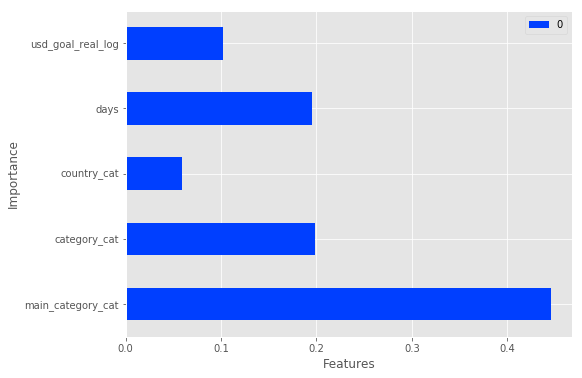

In [112]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf_DT.feature_importances_)
plt.style.use('seaborn-bright')

pd.DataFrame(clf_DT.feature_importances_, 
             index=["main_category_cat","category_cat", "country_cat", "days", "usd_goal_real_log"]).plot.barh(figsize=(8,6))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [117]:
# 決定木の描画
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(clf_DT, out_file=dot_data,  
                     feature_names=["main_category_cat","category_cat", "country_cat", "days", "usd_goal_real_log"],  
                     class_names=["0","1", "2", "3", "4"],  
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

InvocationException: GraphViz's executables not found

## 8 ランダムフォレスト

In [118]:
from sklearn.ensemble import RandomForestClassifier

clf_RF = RandomForestClassifier(n_estimators=10, max_depth=2, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf_RF.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

score= 0.6178676415165448


In [119]:
# ラベルを予測
y_pred = clf_RF.predict(X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 61.969%
適合率（Precision） = 61.917%
再現率（Recall） = 94.050%
F1値（F1-score） = 74.673%


In [120]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = CR-FD 成功', '正解 = CR－FD失敗'], 
                        columns=['予測 = CR-FD成功', '予測 = CR-FD失敗'])
conf_mat

,予測 = CR-FD成功,予測 = CR-FD失敗
正解 = CR-FD 成功,37191,2353
正解 = CR－FD失敗,22875,3916


#### 説明変数の重要度を出力する、決定木の図化

[0.45908409 0.34022514 0.00337011 0.06797181 0.12934885]


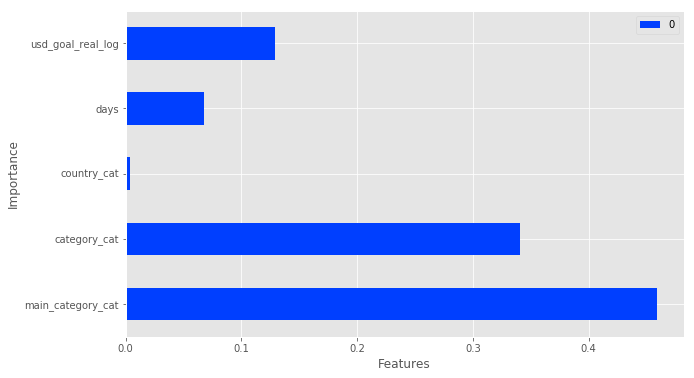

In [126]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf_RF.feature_importances_)
pd.DataFrame(clf_RF.feature_importances_, 
             index=["main_category_cat","category_cat", "country_cat", "days", "usd_goal_real_log"]).plot.barh(figsize=(10,6))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [ ]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

for i, est in enumerate(clf.estimators_):
    print(i)
    
    # 決定木の描画
    dot_data = StringIO() #dotファイル情報の格納先
    export_graphviz(est, out_file=dot_data,  
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True) 
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    display(Image(graph.create_png()))

## 9 アダブースティング

In [127]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf_AB = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, min_samples_leaf=2,  min_samples_split=2, 
                                                   random_state=1234, criterion="gini"), n_estimators=10, random_state=1234)
clf_AB.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))



score= 0.6178676415165448


In [128]:
# ラベルを予測
y_pred = clf_AB.predict(X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 66.965%
適合率（Precision） = 69.597%
再現率（Recall） = 79.168%
F1値（F1-score） = 74.074%


In [129]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = CR-FD 成功', '正解 = CR－FD失敗'], 
                        columns=['予測 = CR-FD成功', '予測 = CR-FD失敗'])
conf_mat

,予測 = CR-FD成功,予測 = CR-FD失敗
正解 = CR-FD 成功,31306,8238
正解 = CR－FD失敗,13676,13115


#### 説明変数の重要度を出力する、決定木の図化

[0.18039963 0.1309812  0.01774725 0.56379573 0.10707618]


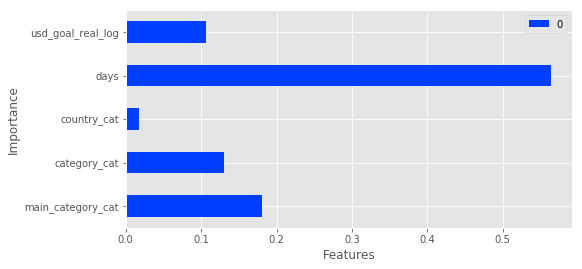

In [132]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf_AB.feature_importances_)
pd.DataFrame(clf_AB.feature_importances_,
             index=["main_category_cat","category_cat", "country_cat", "days", "usd_goal_real_log"]).plot.barh(figsize=(8,4))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [ ]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

for i, est in enumerate(clf.estimators_):
    print(i)
    
    # 決定木の描画
    dot_data = StringIO() #dotファイル情報の格納先
    export_graphviz(est, out_file=dot_data,
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True,precision=5) 
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    display(Image(graph.create_png()))
    graph.write_pdf('iris_ada_{}.pdf'.format(i))

## 最終稿は、上記事情への記入


*****

*****
# ★★以降は、自身の課題の覚書